300 600 900 1200 


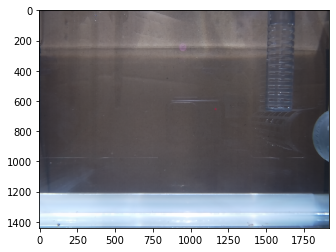

In [1]:
import glob
from utils import vread
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import deepcopy
import os

NAME = "GH010005"
files = sorted(glob.glob("split/" + NAME + "*.mp4"))

i = 17
file = files[i]
vid = vread(file)

back_file = file.replace("split", "back").replace("mp4", "png")
if os.path.exists(back_file):
    back = cv2.imread(back_file)
else:
    back = np.array(vid).mean(0).astype(np.uint8)
    cv2.imwrite(back_file, back)

H, W, C = back.shape
plt.imshow(back)
plt.show()

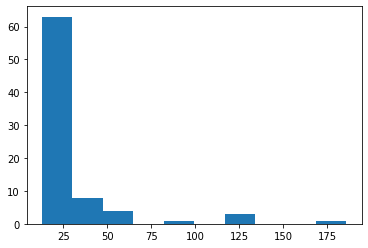

18


In [2]:
# 魚が居たときのthreshを集めるべきではある
# けどあとで魚検出器が出来そうだしいっか
# 1frameずつthreshを求めていると、魚が大きく写った場合と小さく写った場合で差が出てしまう
threshs = []
for t in range(2, len(vid)-2):
    if not t % 15 == 0:
        continue
    img = np.array(vid[t-2:t+3]).mean(0).astype(np.uint8)  # PARAM
    diff_img = cv2.absdiff(back, img)
    a = np.sum(diff_img, 2).reshape(-1)
    threshs.append(int(np.percentile(a, 99)))
plt.hist(threshs)
plt.show()
thresh = int(np.percentile(threshs, 50)); print(thresh)

82.07960792937702 15915.5 1306338.0


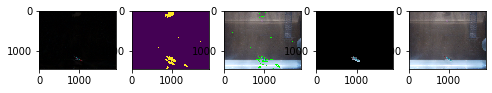

87.87441438347764 20384.5 1791276.0


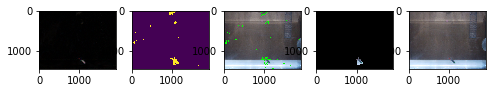

132.94014813973948 17618.5 2342206.0


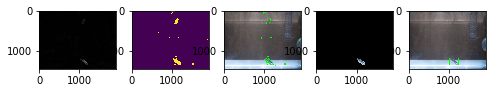

160.1128882945896 19444.0 3113235.0


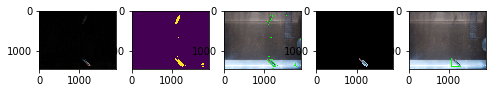

180.85460046271578 19666.5 3556777.0


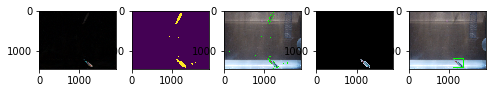

194.06190579083838 18512.0 3592474.0


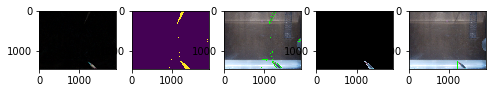

173.4280701754386 15960.0 2767912.0


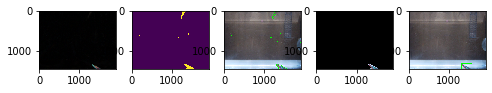

103.82104218831199 10583.5 1098790.0


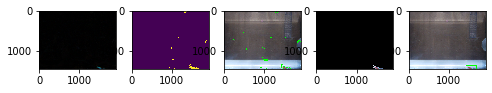

74.10086179380785 7832.5 580395.0


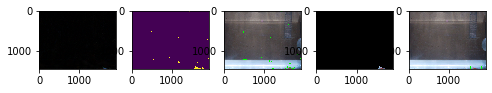

0 0 0
0 0 0
0 0 0
0 0 0
20.593265854162365 9682.0 199384.0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
123.38327846729507 24453.5 3017153.0


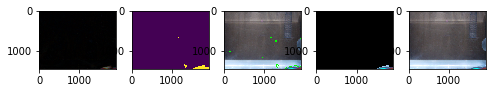

173.52745201944566 43403.0 7531612.0


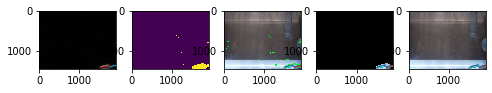

166.68974971256745 45228.0 7539044.000000001


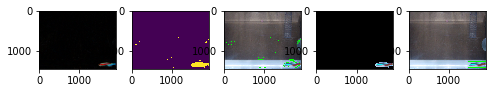

147.27577489324636 47071.0 6932418.0


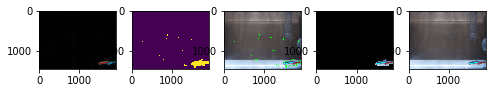

124.22003753032175 54622.5 6785209.0


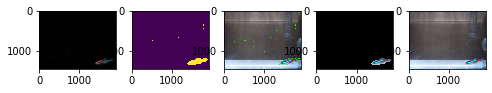

173.58046005855292 59775.0 10375772.0


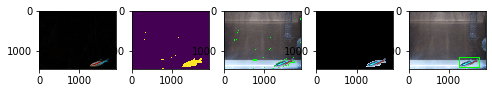

203.13574729571886 29536.5 5999919.0


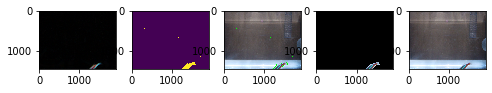

0 0 0
0 0 0
21.134663341645886 5213.0 110175.0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
0 0 0
26.497939281360654 17227.0 456480.0
34.09735304228257 7272.5 247973.0
0 0 0
18.640316205533598 17710.0 330120.0
0 0 0
81.09020928554246 8314.0 674184.0


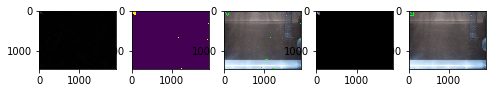

78.6468528664974 18707.5 1471286.0


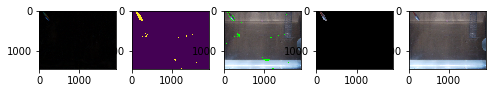

88.67525470741985 18747.0 1662395.0


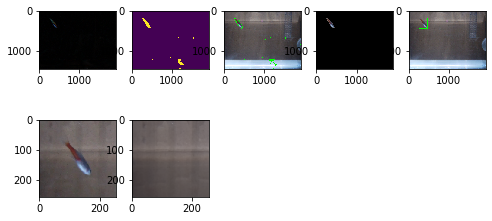

84.45992012150532 8888.5 750722.0


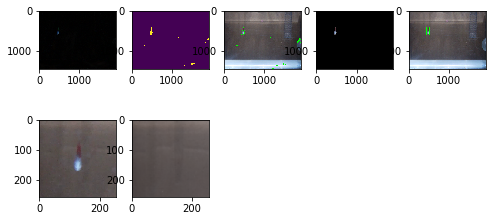

102.50300792646718 19365.5 1985022.0


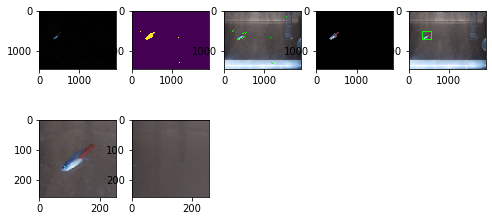

134.7009041259351 21789.0 2934998.0


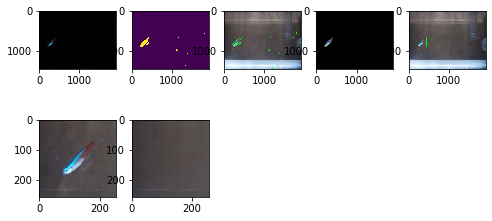

143.01929165873662 28898.5 4133043.0


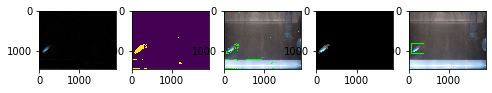

135.47686578474463 23093.5 3128635.0


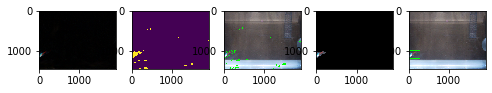

124.28353658536585 13776.0 1712130.0


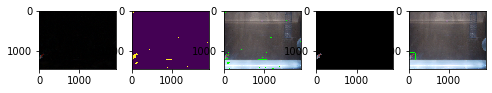

77.60359220844929 11859.0 920301.0000000001


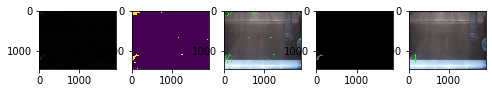

38.7021735330109 8580.5 332084.0
42.4732361516035 8575.0 364208.0
178.5079351679892 11846.0 2114605.0


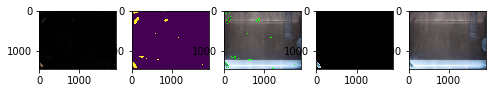

152.71564333526155 18151.5 2772018.0


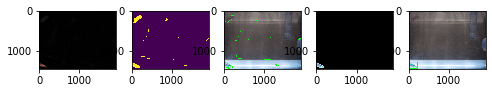

139.69526333222922 25661.5 3584790.0


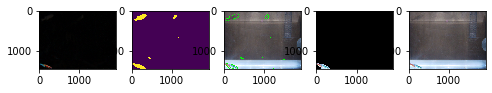

146.8787468878041 25504.5 3746069.0


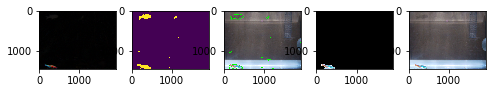

186.24171707712168 19754.5 3679112.0


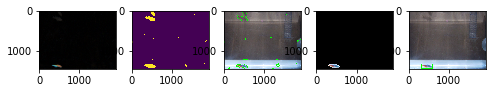

179.19814506779576 19839.0 3555112.0


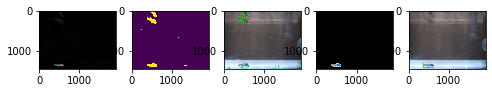

165.97178052919364 15911.0 2640777.0


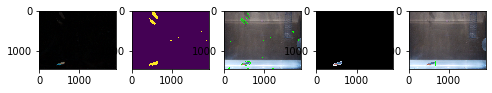

122.12956093613003 14827.0 1810815.0


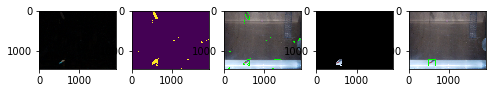

60.19350167013151 21405.5 1288472.0


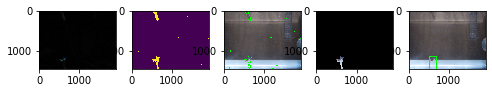

46.81121711477306 5188.5 242880.0
84.19446544684712 13226.0 1113556.0


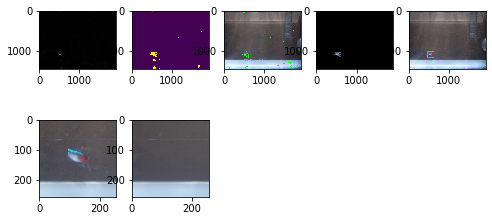

129.15349751054947 22394.5 2892328.0


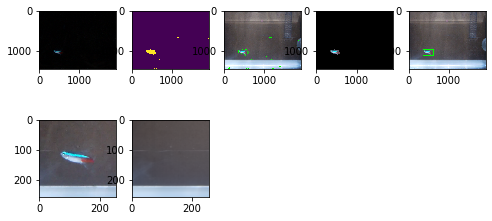

137.87129048030994 26587.0 3665584.0000000005


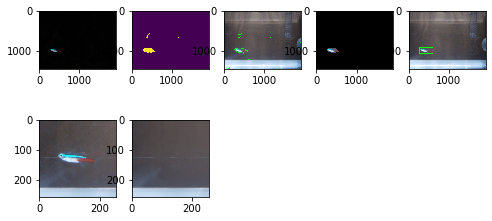

142.74298295861377 27932.0 3987096.9999999995


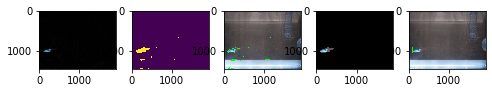

129.0455058717254 26568.0 3428481.0000000005


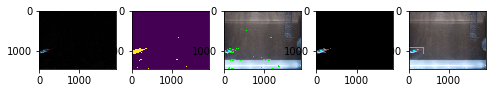

84.81012386723148 9324.5 790812.0


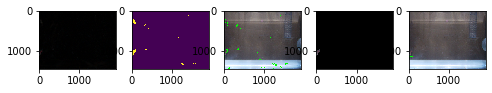

52.55195219585775 8618.5 452919.00000000006
0 0 0


In [3]:
for t in range(2, len(vid)-2):
    if not t % 15 == 0:
        continue
    plt.figure(figsize=(8,4))
    img = np.array(vid[t-2:t+3]).mean(0).astype(np.uint8)  # PARAM
    diff_img = cv2.absdiff(back, img)
    diff_all = np.sum(diff_img)
    plt.subplot(2,5,1)
    plt.imshow(diff_img)  # diff_img * 2 or diff_img + back * mask * 0.8(透過率の再現)

    img = np.sum(diff_img, 2)
    img = cv2.blur(img,(16,16))  # PARAM
    img = np.where(img < thresh, 0, 1).astype(np.uint8)  # PARAM  # 12 ~ 21(しっぽが見えるギリギリライン)
    plt.subplot(2,5,2)
    plt.imshow(img)

    contours, hierarchy = cv2.findContours(deepcopy(img), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours.sort(key=cv2.contourArea, reverse=True)
    img = cv2.drawContours(deepcopy(vid[t]), contours, -1, (0,255,0), 10)
    plt.subplot(2,5,3)
    plt.imshow(img)

    best_i = None
    best_diff_mean = 0
    best_s = 0
    for j, c in enumerate(contours[:5]):  # PARAM
        mask = cv2.fillConvexPoly(deepcopy(diff_img), c, (0,0,0))
        s = cv2.contourArea(c)
        if s <= 5000:
            continue
        diff_mean = (diff_all - np.sum(mask)) / s
#         print(diff_mean, s)
        if best_diff_mean < diff_mean:
            best_diff_mean = diff_mean
            best_i = j
            best_s = s
    print(best_diff_mean, best_s, best_diff_mean * best_s)
    if best_i == None or best_diff_mean * best_s < 500000:
        plt.close()
        continue
    mask = cv2.fillConvexPoly(deepcopy(vid[t]), contours[best_i], (0,0,0))  # TODO きれいじゃない
    plt.subplot(2,5,4)
    plt.imshow(deepcopy(vid[t]) - mask)

    x,y,w,h = cv2.boundingRect(contours[best_i])
    img = cv2.rectangle(deepcopy(vid[t]),(x,y),(x+w,y+h),(0,255,0),10)
    plt.subplot(2,5,5)
    plt.imshow(img)

    margin = 128
    if w > h:
        margin_x = margin
        margin_y = margin + int((w-h)/2)
    else:
        margin_y = margin
        margin_x = margin + int((h-w)/2)

    if 0 <= y-margin_y and y+h+margin_y < H and 0 <= x-margin_x and x+w+margin_x < W:
        img_t = deepcopy(vid[t])[y-margin_y:y+h+margin_y, x-margin_x:x+w+margin_x]
        plt.subplot(2,5,6)
        img_t = cv2.resize(img_t, (256, 256))
        plt.imshow(img_t)
        back_t = back[y-margin_y:y+h+margin_y, x-margin_x:x+w+margin_x]
        plt.subplot(2,5,7)
        back_t = cv2.resize(back_t, (256, 256))
        plt.imshow(back_t)

    plt.show()